# Two-layer Neural Network Workbook for CS145 Homework 3

----
<span style="color:red">**PRINT YOUR NAME AND UID HERE!**</span>

NAME: Wu, Michael UID: 404751542

----


Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a two layer neural network.

---

Import libraries and define relative error function, which is used to check results later. 

In [1]:
import random
import numpy as np
from cs145.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass.

In [2]:
from lib.neural_net import TwoLayerNet

In [3]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [4]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231233889892e-08


### Forward pass loss

The total loss includes data loss (MSE) and regularization loss, which is,

$$L = L_{data}+L_{reg} = \frac{1}{2N}\sum_{i=1}^{N}\left(\boldsymbol{y}_{\text{pred}}-\boldsymbol{y}_{\text{target}}\right)^2 + \frac{\lambda}{2} \left(||W_1||^2 + ||W_2||^2 \right)$$

More specifically in multi-class situation, if the output of neural nets from one sample is $y_{\text{pred}}=(0.1,0.1,0.8)$ and $y_{\text{target}}=(0,0,1)$ from the given label, then the MSE error will be $Error=(0.1-0)^2+(0.1-0)^2+(0.8-1)^2=0.06$

Implement data loss and regularization loss. In the MSE function, you also need to return the gradients which need to be passed backward. This is similar to batch gradient in linear regression. Test your implementation of loss functions. The Difference should be less than 1e-12.

In [5]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss_MSE = 3.775701133135245 # check this number

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss_MSE)))

Difference between your loss and correct loss:
0.0


### Backward pass (You do not need to implemented this part)

We have already implemented the backwards pass of the neural network for you.  Run the block of code to check your gradients with the gradient check utilities provided. The results should be automatically correct (tiny relative error).

If there is a gradient error larger than 1e-8, the training for neural networks later will be negatively affected.

In [6]:
from cs145.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 6.642864611140192e-10
b2 max relative error: 2.4554844805570154e-11
W1 max relative error: 7.554564328075232e-10
b1 max relative error: 7.382451041178829e-10


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the linear regression.

Final training loss:  0.26805752112790193


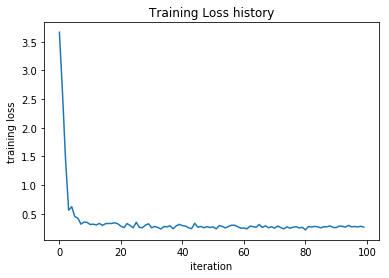

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [8]:
from cs145.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cs145/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 15-18%.

In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-5, learning_rate_decay=0.95,
            reg=0.1, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 1.0000477636152436
iteration 100 / 1000: loss 0.9990569291920572
iteration 200 / 1000: loss 0.9977657718586517
iteration 300 / 1000: loss 0.9955998225596672
iteration 400 / 1000: loss 0.9906783608102978
iteration 500 / 1000: loss 0.9798023308051755
iteration 600 / 1000: loss 0.9577504024675703
iteration 700 / 1000: loss 0.9358526467884126
iteration 800 / 1000: loss 0.9250220881544509
iteration 900 / 1000: loss 0.9166617563494448
Validation accuracy:  0.171


In [10]:
stats['train_acc_history']

[0.09, 0.165, 0.2, 0.165, 0.195]

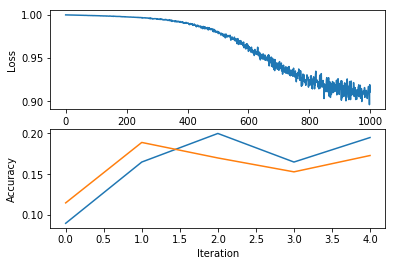

In [11]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

### Questions:

The training accuracy isn't great. It seems even worse than simple KNN model, which is not as good as expected.

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?

### Answers:

(1) For one, the loss function behaviour indicates that more training could lead to a better classifier. We haven't run gradient
descent for long enough where the loss function stops decreasing. As the loss function decreases, small changes cause
more erratic behaviour which prevents it from improving.

(2) We can train with a larger initial learning rate so the loss function decreases faster, then we can change the learning rate decay and number of iterations so that our classifier can be more stable as the number of iterations increase. Additionally we can increase the batch size so that our gradient points in the right direction more often.

---

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net. 

**Important: Think about whether you should retrain a new model from scratch every time your try a new set of hyperparameters. **

iteration 0 / 3000: loss 1.0002923944670383
iteration 100 / 3000: loss 0.770246872416744
iteration 200 / 3000: loss 0.7545168314598255
iteration 300 / 3000: loss 0.7259039582160894
iteration 400 / 3000: loss 0.731606413284616
iteration 500 / 3000: loss 0.7301658935482049
iteration 600 / 3000: loss 0.7163650504026785
iteration 700 / 3000: loss 0.7246834777259559
iteration 800 / 3000: loss 0.7197662283425441
iteration 900 / 3000: loss 0.7174594650007665
iteration 1000 / 3000: loss 0.7153145000538825
iteration 1100 / 3000: loss 0.6954353326071597
iteration 1200 / 3000: loss 0.68217041905767
iteration 1300 / 3000: loss 0.7071104541524645
iteration 1400 / 3000: loss 0.6893476977127924
iteration 1500 / 3000: loss 0.6795034407556725
iteration 1600 / 3000: loss 0.6887067701458492
iteration 1700 / 3000: loss 0.6879371170499285
iteration 1800 / 3000: loss 0.6769046015868724
iteration 1900 / 3000: loss 0.6876356794275016
iteration 2000 / 3000: loss 0.6700234174547846
iteration 2100 / 3000: loss 0

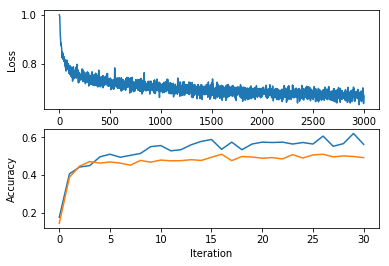

== Best parameter settings ==
num_iters=3000, batch_size=500, learning_rate=0.001, learning_rate_decay=0.95, reg=0.5
Best accuracy on validation set: 0.501


In [12]:
best_net = None # store the best model into this 

input_size = 32 * 32 * 3 # do not change
hidden_size = 50 # do not change
num_classes = 10 # do not change
best_valacc = 0 # do not change

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train, y_train, X_val, y_val,
        num_iters=3000, batch_size=500,
        learning_rate=0.001, learning_rate_decay=0.95,
        reg=0.5, verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
if val_acc > best_valacc:
    best_valacc = val_acc
    best_net = net
    
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

print("== Best parameter settings ==")
print("num_iters=3000, batch_size=500, learning_rate=0.001, learning_rate_decay=0.95, reg=0.5")
print("Best accuracy on validation set: {}".format(best_valacc))

### Quesions

(1) What is your best parameter settings? (Output from the previous cell)

(2) What parameters did you tune? How are they changing the performance of nerural network? You can discuss any observations from the optimization.

### Answers

(1) num_iters=3000, batch_size=500, learning_rate=0.001, learning_rate_decay=0.95, reg=0.5

(2) I mainly tuned the learning rate. Since the search space for the parameters was very high, I knew
that it would not be time efficient to test out every combination of parameters in a large number of nested loops. I made the initial learning rate as high as it could go, upped the batch size, and raised the number of iterations. I found that changing the regularization did not do much to improve performance, since it seems that the weight vectors are not too big to begin with. Naturally, increasing learning rate meant that the loss function would decrease faster initially. With more iterations, this eventually resulted in an accuracy that was above the 50 percent threshold that would lead to full points. After achieving this I stopped fiddling with the parameters and removed any loops I made for brevity. 

---

## Visualize the weights of your neural networks

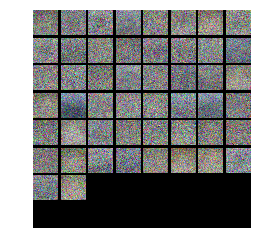

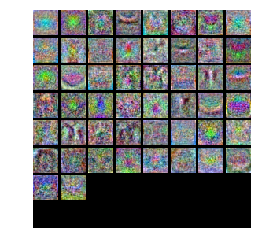

In [13]:
from cs145.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

### Questions:

What differences do you see in the weights between the suboptimal net and the best net you arrived at? What do the weights in neural networks probably learn after training?

### Answer:
The suboptimal net appears to show less detail in its weights, as it looks smoother like noise. The better network looks like
it can recognize basic shapes. Since we are training on images, this makes sense. The weights probably learns key features of what each type of image looks like.


---

## Evaluate on test set 

In [14]:
test_acc = (best_net.predict(X_test) == y_test).mean()
#test_acc = (subopt_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.483


### Questions:
(1) What is your test accuracy by using the best NN you have got? How much does the performance increase compared with kNN? Why can neural networks perform better than kNN?

(2) Do you have any other ideas or suggestions to further improve the performance of neural networks other than the parameters you have tried in the homework? 

### Answers:
(1) The test accuracy I obtained was 0.483. This is approximately 2.5-3x better accuracy than kNN. Neural networks can perform
better than kNN since they can learn more complex functions, and are not restricted by a simple model such as kNN.

(2) In this homework, we could not change the number of hidden layers or the size of the hidden layer. Increasing these could
potentially allow even more complex functions to be learned. Along with massive amounts of data and computing resources that would allow us to train our classifier, these changes could potentially improve the performance of this neural network by a
large margin. Clearly google's image recognition classifiers perform better than ours, so it can be done.

---

## Bonus Question: Change MSE Loss to Cross Entropy Loss

This is a bonus question. If you finish this (cross entropy loss) correctly, you will get **up to 20 points** (add up to your HW3 score). 

Note: From grading policy of this course, your maximum points from homework are still 25 out of 100, but you can use the bonus question to make up other deduction of other assignments.

Pass output scores in networks from forward pass into softmax function. The softmax function is defined as,
$$p_j = \sigma(z_j) = \frac{e^{z_j}}{\sum_{c=1}^{C} e^{z_c}}$$
After softmax, the scores can be considered as probability of $j$-th class.

The cross entropy loss is defined as,
$$L = L_{\text{CE}}+L_{reg} = \frac{1}{N}\sum_{i=1}^{N} \log \left(p_{i,j}\right)+ \frac{\lambda}{2} \left(||W_1||^2 + ||W_2||^2 \right)$$

To take derivative of this loss, you will get the gradient as,
$$\frac{\partial L_{\text{CE}}}{\partial o_i} = p_i - y_i $$

More details about multi-class cross entropy loss, please check [http://cs231n.github.io/linear-classify/](http://cs231n.github.io/linear-classify/) and [more explanation](https://deepnotes.io/softmax-crossentropy) about the derivative of cross entropy.

Change the loss from MSE to cross entropy, you only need to change you ```MSE_loss(x,y)``` in ```TwoLayerNet.loss()``` function to ```softmax_loss(x,y)```.

**Now you are free to use any code to show your results of the two-layer networks with newly-implemented cross entropy loss. You can use code from previous cells.**

In [ ]:
input_size = 32 * 32 * 3 # do not change
hidden_size = 50 # do not change
num_classes = 10 # do not change
best_valacc = 0 # do not change

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train, y_train, X_val, y_val,
        num_iters=3000, batch_size=500,
        learning_rate=0.001, learning_rate_decay=0.95,
        reg=0.5, verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
    
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

show_net_weights(net)